<a href="https://colab.research.google.com/github/bomiiisong/DeepLearning-with-Python/blob/master/NLP/LSTM_IMDB_GloVe_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMDB - GloVe with LSTM

> ## NLP(Natural Language Processing)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

### Import Keras

* keras version check

In [ ]:
import keras

keras.__version__

'2.4.3'

## I. IMDB Data_Set

> ### 1) Load IMDB Data_Set

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls -l /content/drive/My\ Drive/Colab\ Notebooks/datasets/IMDB.zip

-rw------- 1 root root 60711700 Mar 31 06:21 '/content/drive/My Drive/Colab Notebooks/datasets/IMDB.zip'


In [ ]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/IMDB.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: __MACOSX/aclImdb/train/pos/._7754_9.txt  
  inflating: aclImdb/train/pos/7755_9.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7755_9.txt  
  inflating: aclImdb/train/pos/7756_10.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7756_10.txt  
  inflating: aclImdb/train/pos/7757_9.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7757_9.txt  
  inflating: aclImdb/train/pos/7758_7.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7758_7.txt  
  inflating: aclImdb/train/pos/7759_10.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7759_10.txt  
  inflating: aclImdb/train/pos/775_7.txt  
  inflating: __MACOSX/aclImdb/train/pos/._775_7.txt  
  inflating: aclImdb/train/pos/7760_10.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7760_10.txt  
  inflating: aclImdb/train/pos/7761_10.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7761_10.txt  
  inflating: aclImdb/train/pos/7762_8.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7762_8.txt  
  inflating:

> ### 2) 'texts' and 'labels' Data

* 'texts' : 문자열 리스트(영화 감상평)
* 'lebels' : 감상평 리뷰(긍정/부정)

In [ ]:
import os

imdb_dir = 'aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type) # aclImdb/train/neg, aclImdb/train/pos
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
                # 0:부정
            else:
                labels.append(1)
                # 1:긍정

In [ ]:
len(texts), len(labels)

(25000, 25000)

## II. Tensor Transformation

> ### 1) X_train and X_valid : (25000, 2000)

* vectorization
    * (25000, 2000)

In [ ]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

maxlen = 2000        # 2000개 단어까지 적용
max_words = 10000    # 빈도 높은 10000개 단어 사용

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print(f'{len(word_index)} 개의 고유한 토큰을 찾았습니다.')

# (25000, 2000) 으로 패딩
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('데이터 텐서 크기 : ', data.shape)
print('레이블 텐서 크기 : ', labels.shape)

# 샘플 데이터 랜덤화
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# 학습 데이터, 검증 데이터로 분할
training_samples = 15000
validation_samples = 10000

X_train = data[:training_samples]
y_train = labels[:training_samples]
X_valid = data[training_samples : training_samples + validation_samples]
y_valid = labels[training_samples : training_samples + validation_samples]

88582 개의 고유한 토큰을 찾았습니다.
데이터 텐서 크기 :  (25000, 2000)
레이블 텐서 크기 :  (25000,)


## III. GloVe(Global Vectors for word representation)

* 영문 위키디피아를 사용한 사전 임베딩
* https://nlp.stanford.edu/projects/glove/

> ### 1) 'GloVe.zip' 압축풀기

In [ ]:
!ls -l /content/drive/My\ Drive/Colab\ Notebooks/datasets/GloVe.zip

-rw------- 1 root root 862182613 Mar 31 06:22 '/content/drive/My Drive/Colab Notebooks/datasets/GloVe.zip'


In [ ]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/GloVe.zip

Archive:  /content/drive/My Drive/Colab Notebooks/datasets/GloVe.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


> ### 2) 'glove.6B.100d.txt' 사전 학습 임베딩

* 'glove.6B.100d.txt' 파일 파싱
    * 단어에 매핑되는 표현벡터 인덱스 생성

In [ ]:
glove_dir = '.'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding='utf8')
for line in f:
    values = line.split()   # values[0] : 단어, values[1:] : 해당 단어 벡터값
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs   # dict 형태로 저장
f.close()

print(f'{len(embeddings_index)} 개의 단어 벡터를 찾았습니다.')

400000 개의 단어 벡터를 찾았습니다.


* 매핑 확인

In [ ]:
embeddings_index['apple'].shape

(100,)

> ### 3) 임베딩 행렬 생성

* (10000, 100)

In [ ]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim)) # max_words : 빈도 높은 단어 100개

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # 임베딩 인덱스에 없는 단어는 모두 0으로 처리
            embedding_matrix[i] = embedding_vector

* 확인

In [ ]:
embedding_matrix.shape

(10000, 100)

## IV. Keras Embedding Modeling

> ### 1) Model Define

* 모델 신경망 구조 정의
    * Embedding Dimension : 100

In [ ]:
from keras import models
from keras import layers

imdb = models.Sequential()

imdb.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen))

imdb.add(layers.LSTM(16))
imdb.add(layers.Dropout(0.5))
imdb.add(layers.Dense(1, activation='sigmoid'))

* 'GloVe' Embedding Load
    * Embedding Layer의 Parameters 동결

In [ ]:
imdb.layers[0].set_weights([embedding_matrix])  # 0번째 layer : Embedding layer의 가중치를 glove의 가중치로 넣기
imdb.layers[0].trainable = False  # 가중치가 학습되지 않도록 Freezing

* model summary

In [ ]:
imdb.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 100)         1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                7488      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 1,007,505
Trainable params: 7,505
Non-trainable params: 1,000,000
_________________________________________________________________


> ### 2) Model Compile

In [ ]:
imdb.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

> ### 3) Model Fit

* 약 15분 소요

In [ ]:
%%time

Hist_imdb = imdb.fit(X_train, y_train, epochs=100, batch_size=512,
                     validation_data=(X_valid, y_valid))

Epoch 1/100
30/30 [==============================] - 42s 304ms/step - loss: 0.7048 - accuracy: 0.5008 - val_loss: 0.6863 - val_accuracy: 0.5455
Epoch 2/100
30/30 [==============================] - 8s 283ms/step - loss: 0.6869 - accuracy: 0.5412 - val_loss: 0.6747 - val_accuracy: 0.5909
Epoch 3/100
30/30 [==============================] - 8s 283ms/step - loss: 0.6691 - accuracy: 0.5956 - val_loss: 0.5976 - val_accuracy: 0.6900
Epoch 4/100
30/30 [==============================] - 8s 281ms/step - loss: 0.5973 - accuracy: 0.7021 - val_loss: 0.5511 - val_accuracy: 0.7358
Epoch 5/100
30/30 [==============================] - 8s 280ms/step - loss: 0.6245 - accuracy: 0.6878 - val_loss: 0.7471 - val_accuracy: 0.5032
Epoch 6/100
30/30 [==============================] - 8s 283ms/step - loss: 0.7028 - accuracy: 0.5551 - val_loss: 0.6381 - val_accuracy: 0.6618
Epoch 7/100
30/30 [==============================] - 8s 284ms/step - loss: 0.6432 - accuracy: 0.6341 - val_loss: 0.5995 - val_accuracy: 0.694

> ### 4) 학습 결과 시각화

* Loss Visualization

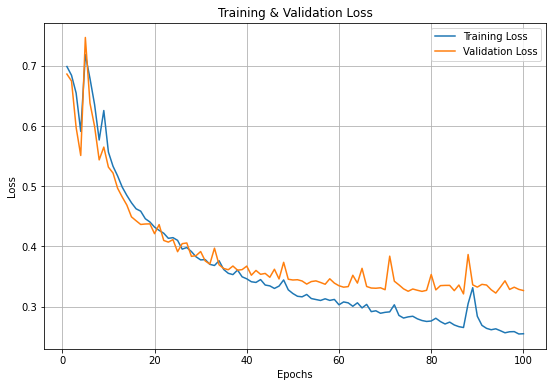

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_imdb.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_imdb.history['loss'])
plt.plot(epochs, Hist_imdb.history['val_loss'])
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()

* Accuracy Visualization

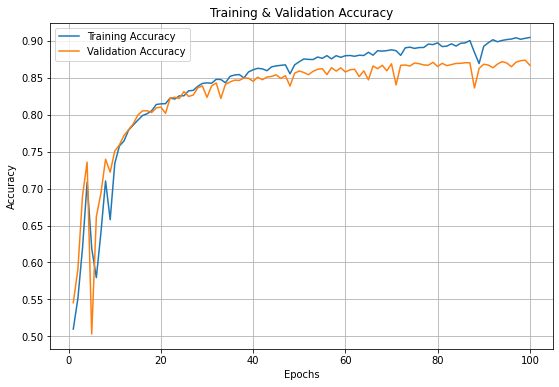

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_imdb.history['accuracy']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_imdb.history['accuracy'])
plt.plot(epochs, Hist_imdb.history['val_accuracy'])
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()
plt.show()

> ### 5) Model Evaluate

* Loss & Accuracy

In [ ]:
loss, accuracy = imdb.evaluate(X_valid, y_valid)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

313/313 [==============================] - 9s 29ms/step - loss: 0.3267 - accuracy: 0.8670
Loss = 0.32672
Accuracy = 0.86700
